# Box Plot

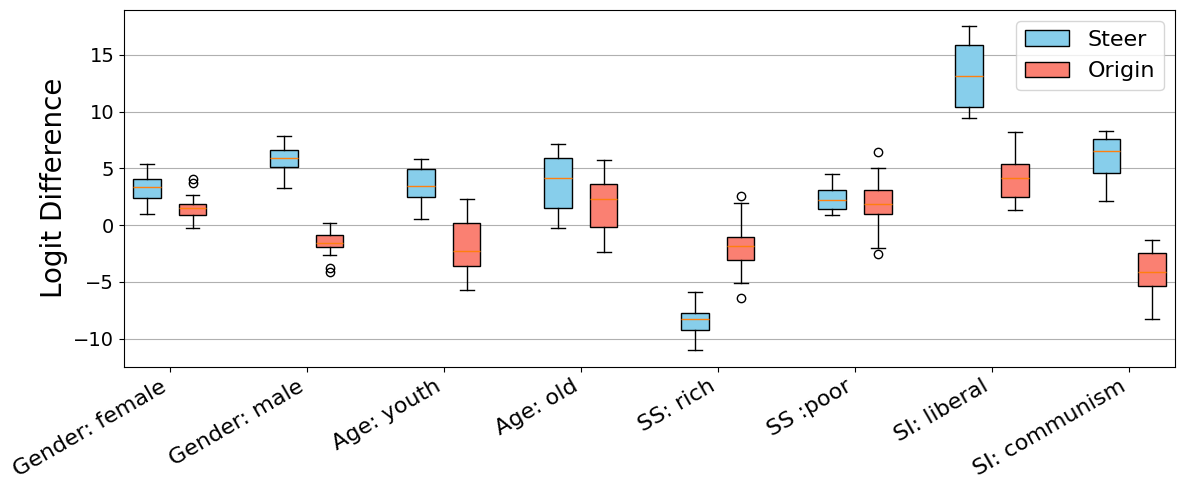

In [16]:
import json
import matplotlib.pyplot as plt
import os

# Directory containing the result files
directory = "./result/gemma-2b-it-200"

# Get all JSON files in the directory
data_paths = sorted([os.path.join(directory, file) for file in os.listdir(directory) if file.endswith(".json")])

# Label mapping
labels = [
    "Gender: female", "Gender: male", 
    "Age: youth", "Age: old",
    "SS: rich", "SS :poor", 
    "SI: liberal", "SI: communism"
]

# Define filtering categories (each pair of files corresponds to a filter)
filter_mappings = ["gender", "gender", "age", "age", "socioeconomic status", "socioeconomic status", "social ideology", "social ideology"]

# Initialize lists to store logit differences
logit_difference_steer_all = []
logit_difference_origin_all = []

# Read data from JSON files
for i, data_path in enumerate(data_paths):
    try:
        with open(data_path, encoding='utf-8') as f:
            data = json.load(f)

        # Determine the correct filter mapping (based on the file index)
        current_filter = filter_mappings[i]

        # Apply filtering using the correct mapping for this file
        filtered_data = [
            {key: value for key, value in item.items() if current_filter in key.lower()}
            for item in data
        ]
        filtered_data = [item for item in filtered_data if item]  # Remove empty dictionaries

        # Collect "logit difference steer" and "logit difference origin"
        logit_difference_steer = []
        logit_difference_origin = []

        for item in filtered_data:
            for key, value in item.items():
                if isinstance(value, dict):  # Ensure value is a dictionary
                    if "logit difference steer" in value:
                        logit_difference_steer.append(value["logit difference steer"])
                    if "logit difference origin" in value:
                        logit_difference_origin.append(value["logit difference origin"])

        # Append only non-empty lists
        if logit_difference_steer and logit_difference_origin:
            logit_difference_steer_all.append(logit_difference_steer)
            logit_difference_origin_all.append(logit_difference_origin)

    except FileNotFoundError:
        print(f"File {data_path} not found.")
        continue
    except json.JSONDecodeError:
        print(f"File {data_path} is not a valid JSON.")
        continue


# Plot the box plots
plt.figure(figsize=(12, 5))

# Generate positions dynamically: 1,2,4,5,7,8...
num_pairs = len(logit_difference_steer_all)
positions = [i * 3 + j for i in range(num_pairs) for j in (1, 2)]

colors = ['skyblue', 'salmon']  # Colors for steer and origin

# Plot steer and origin with different colors
for i, (steer, origin) in enumerate(zip(logit_difference_steer_all, logit_difference_origin_all)):
    plt.boxplot(
        [steer],
        positions=[positions[2 * i]],  # Position for steer
        widths=0.6,
        patch_artist=True,
        boxprops=dict(facecolor=colors[0])  # Steer gets colors[0]
    )
    plt.boxplot(
        [origin],
        positions=[positions[2 * i + 1]],  # Position for origin
        widths=0.6,
        patch_artist=True,
        boxprops=dict(facecolor=colors[1])  # Origin gets colors[1]
    )

# Customize x-axis
xtick_positions = [(positions[2 * i] + positions[2 * i + 1]) / 2 for i in range(num_pairs)]
plt.xticks(xtick_positions, labels, rotation=30, ha="right", fontsize=16)  # Center labels

plt.ylabel("Logit Difference", fontsize=20)
plt.grid(axis="y")
plt.yticks(fontsize=14)
# Add legend
plt.legend(["Steer", "Origin"], loc="upper right", fontsize=16)

plt.tight_layout()
plt.savefig("effect.png")
plt.show()

# Scaling Law

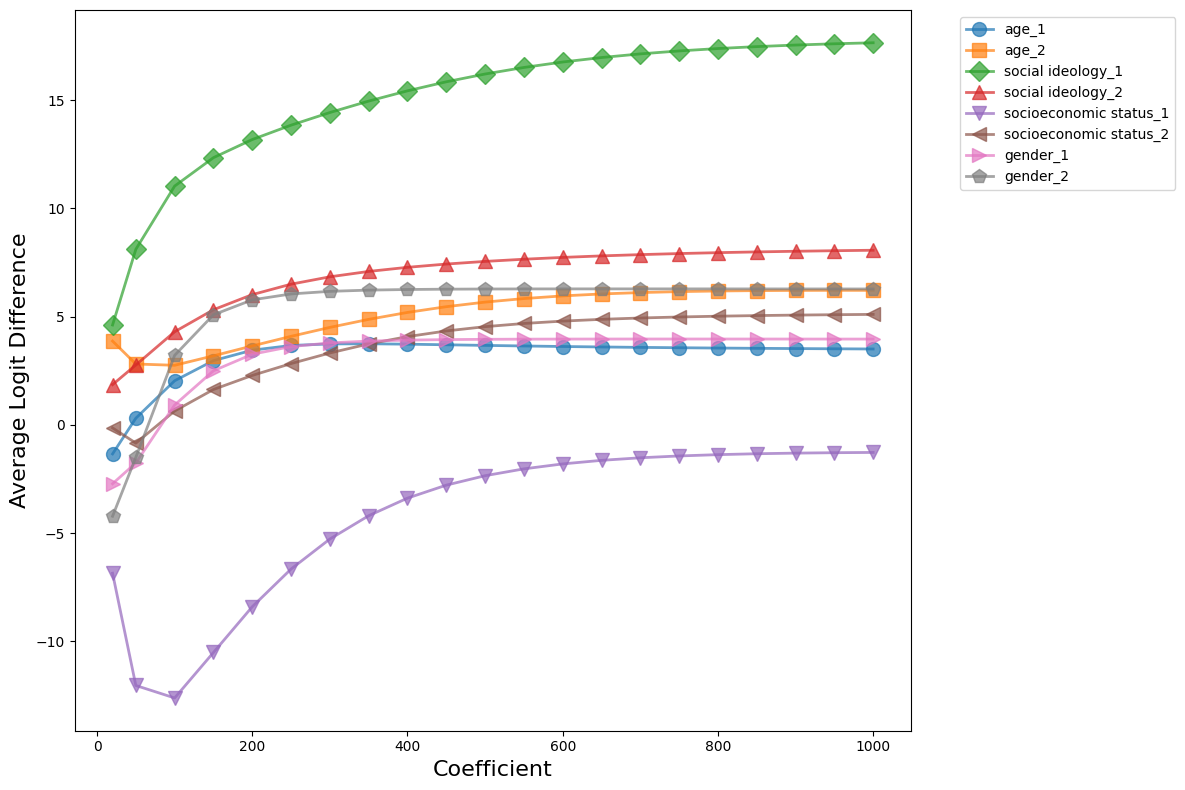

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Path to the folder containing all the directories
base_path = "./result"

filter_mappings = [
    "gender", "gender", 
    "age", "age", 
    "socioeconomic status", "socioeconomic status", 
    "social ideology", "social ideology"
]

# Initialize a dictionary to store results for each filter and file pair (only index 1 or 2 per filter)
results_by_filter_pair = {f"{filter_name}_{idx}": {} for filter_name in set(filter_mappings) for idx in [1, 2]}

for dir_name in sorted(os.listdir(base_path)):
    dir_path = os.path.join(base_path, dir_name)
    
    if os.path.isdir(dir_path):
        for file_index in range(1, 9):  # Process all 8 JSON files in each folder
            json_file_path = os.path.join(dir_path, f"{file_index}.json")
            if os.path.exists(json_file_path):
                # Load the JSON file
                with open(json_file_path, "r") as f:
                    data = json.load(f)
                
                # Get the corresponding filter category and pair index (1 or 2)
                filter_category = filter_mappings[file_index - 1]
                pair_index = 1 if file_index % 2 != 0 else 2  # Map to 1 or 2 based on file index
                filter_key = f"{filter_category}_{pair_index}"

                # Check if data is a list and process accordingly
                if isinstance(data, list):
                    logit_differences = [
                        item["logit difference steer"]
                        for element in data
                        for key, item in element.items()
                        if filter_category in key
                    ]

                # Store the average in the results dictionary for the filter category and pair index
                if logit_differences:
                    avg_logit_difference = np.mean(logit_differences)
                    iteration = int(dir_name.split("-")[-1]) if dir_name.split("-")[-1].isdigit() else 0
                    if iteration not in results_by_filter_pair[filter_key]:
                        results_by_filter_pair[filter_key][iteration] = []
                    results_by_filter_pair[filter_key][iteration].append(avg_logit_difference)

# Calculate final averages for each filter pair and iteration
final_results_by_filter_pair = {
    category: {iteration: np.mean(values) for iteration, values in sorted(iterations.items())}
    for category, iterations in results_by_filter_pair.items()
}

# Define different marker styles for different categories
marker_styles = ['o', 's', 'D', '^', 'v', '<', '>', 'p']

# Plot the trends for all filter pairs
plt.figure(figsize=(12, 8))
for idx, (category, results) in enumerate(final_results_by_filter_pair.items()):
    x_values = list(results.keys())
    y_values = list(results.values())
    plt.plot(x_values, y_values, marker=marker_styles[idx % len(marker_styles)],  markersize=10, linestyle="-", linewidth=2, alpha=0.7, label=category)

plt.xlabel("Coefficient", fontsize=16)
plt.ylabel("Average Logit Difference", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


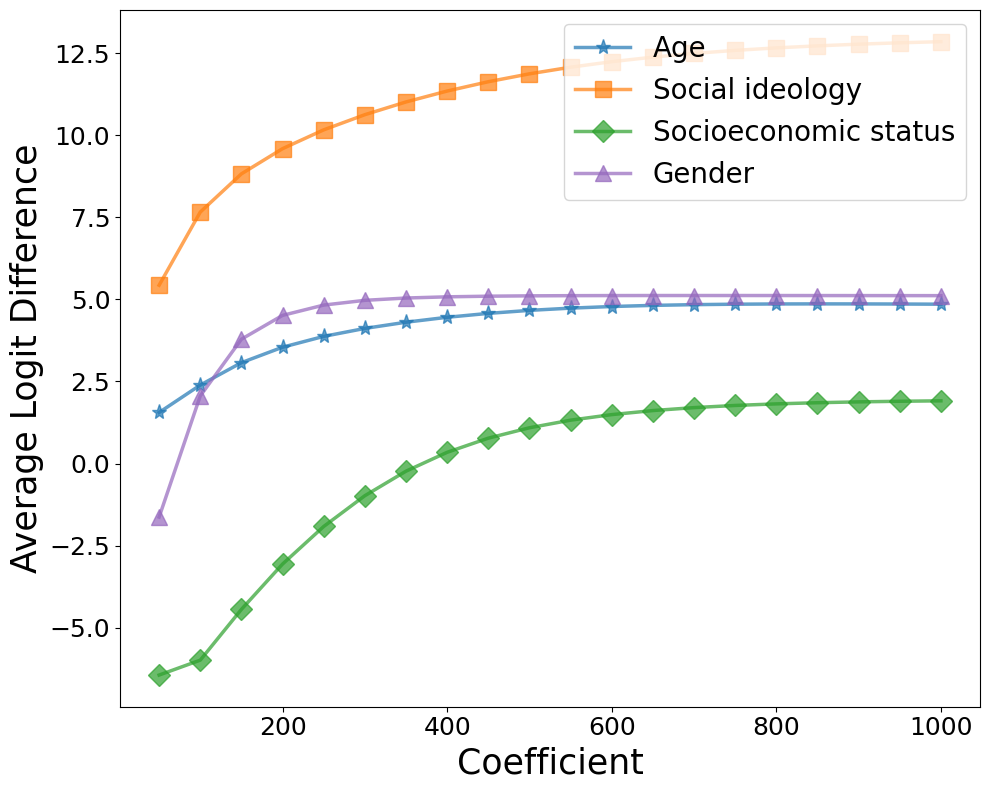

In [13]:

aggregated_results = {}
for category in results_by_filter_pair:
    base_category = category.rsplit("_", 1)[0]  # Extract base category name (e.g., "age")
    if base_category not in aggregated_results:
        aggregated_results[base_category] = {}
    
    for iteration, values in results_by_filter_pair[category].items():
        if iteration not in aggregated_results[base_category]:
            aggregated_results[base_category][iteration] = []
        aggregated_results[base_category][iteration].extend(values)

# Compute the average of merged subcategories
final_aggregated_results = {
    category: {iteration: np.mean(values) for iteration, values in sorted(iterations.items())}
    for category, iterations in aggregated_results.items()
}

# Define different marker styles for different categories
marker_styles = ['*', 's', 'D', '^']

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd']  # Blue, Orange, Green, Purple

# Update category labels to have capitalized first letters
capitalized_labels = {category: category.capitalize() for category in final_aggregated_results.keys()}

# Plot the aggregated trends with updated labels
plt.figure(figsize=(10, 8))
for idx, (category, results) in enumerate(final_aggregated_results.items()):
    x_values = list(results.keys())[1:]
    y_values = list(results.values())[1:]
    plt.plot(
        x_values, 
        y_values, 
        marker=marker_styles[idx % len(marker_styles)], 
        markersize=11, 
        linestyle="-", 
        linewidth=2.5, 
        alpha=0.7, 
        color=colors[idx % len(colors)], 
        label=capitalized_labels[category]
    )

plt.xlabel("Coefficient", fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel("Average Logit Difference", fontsize=25)
plt.legend(loc='upper right', fontsize=20)
plt.tight_layout()
plt.savefig("scalinglaw.png")
plt.show()
